## Import Necessary modules

In [1]:
import pandas as pd     
import numpy as np
import matplotlib.pyplot as plt
import math

## Function to output Water Potential and Water Content for Soil Water Retention Curves (VGM)

In [2]:
def RetCurv_VGM(psand,psilt,pclay):
    #Soil texture constants for sand, silt, and clay
    #Alpha
    sand_a = 0.0016
    silt_a = 0.0034
    clay_a = 0.0099
    #Theta_r (residual moisture contnet)
    sand_tr = 0.061
    silt_tr = 0.083
    clay_tr = 0.107
    #Theta_s (satrated moisture content)
    sand_ts = 0.381
    silt_ts = 0.427
    clay_ts = 0.429
    #n (some are ranges... value is equal to middle value)
    sand_n = (1.29+1.66)/2 #ranges from 1.29 to 1.66
    silt_n = (1.35+1.79)/2 #ranges from 1.35 to 1.79
    clay_n = 1.23
    
    #convert percent soil texture to decimals
    p_sand = psand/100
    p_silt = psilt/100
    p_clay = pclay/100
    
    #genertate paremeters required for VGM
    a = sand_a*p_sand+silt_a*p_silt+clay_a*p_clay
    tr = sand_tr*p_sand+silt_tr*p_silt+clay_tr*p_clay
    ts = sand_ts*p_sand+silt_ts*p_silt+clay_ts*p_clay
    n = sand_n*p_sand+silt_n*p_silt+clay_n*p_clay
    m = 1-(1/n)
    
    #create array representing water content (t) and apply to solve for water potential (h)
    t = np.linspace(tr, ts, num=50)
    S = (t-tr)/(ts-tr)
    h = (((S**(-1/m)-1)**(1/n))/a)/1000000  #devisded by 1000 to make both in units of MPa (assuming that it is orinally in units of Pa****)
    
    return (t,h)
    

## Function to output Water Potential and Water Content For Soil Water Retention Curves (SR)

In [3]:
def RetCurv_SR(p_sand,p_clay):
    def t(p):
    # variable values for the saxton/rawl eq.
        a = -4.396
        b = -0.0715
        c = -4.880*(10**-4)
        d = -4.285*(10**-5)
        e = -3.140
        f = -2.22*(10**-3)
        g = -3.484*(10**-5)
        h = 0.332
        j = -7.251*(10**-4)
        k = 0.1276
        m = -0.108
        n = 0.341
    #Equations to find A and B in the equation as well as water contnet at 10 kPa and saturation, as well as the water potential of air entry
        A = 100*math.exp(a+b*p_clay+c*(p_sand**2)+d*(p_sand**2)*(p_clay))
        B = e+f*(p_clay**2)+g*(p_sand**2)*(p_clay)                         #question about this equation, include the g*(p_sand**2) factor? in paper but not example provided or in paper
        t_s = h+j*(p_sand)+k*(np.log10(p_clay))                            #Theta at saturation
        t_10 = math.exp((2.302-np.log(A))/B)                               #Theta at 1o kPa
        P_e = 100*(m+n*(t_s))
    #Conditional statments for different water potentials ranging from 0 to 1500 kPa (I solved for theta for simplicity)
        if p > 10:
            return (p/A)**(1/B)
        elif P_e < p < 10:
            return ((10-p)*(t_s-t_10)/(10-P_e))+t_10
        elif p < P_e:
            return t_s
    return t                   #returns the theta value

#Create array with values repesenative of water potetnial
P = np.linspace(0,1500,1500)

#Convert water potential to MPa from kPa
P_MPa = P/1000

## WREF Site Soil Water Retention Curves (based on soil texture data)

/opt/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in power


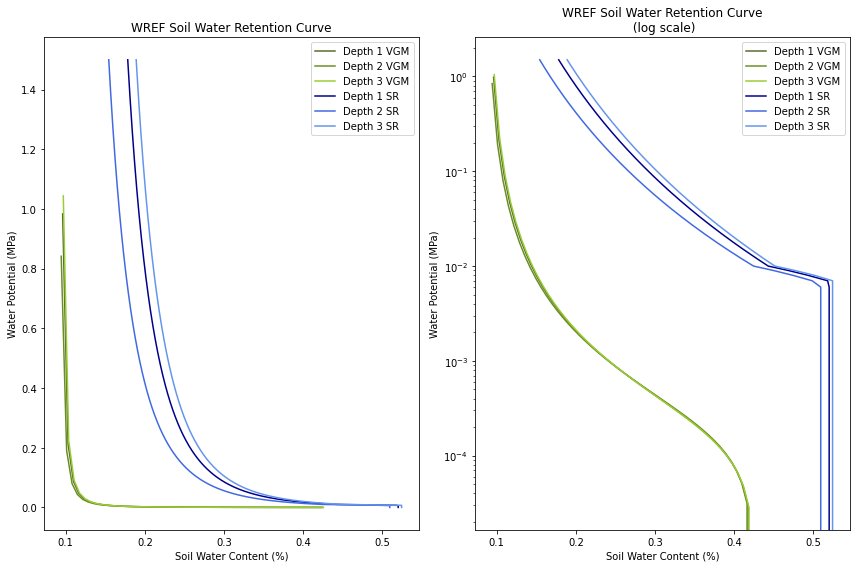

In [4]:
#Read in soil texture .csv file and create dataframe
df = pd.read_csv('SOMMOS_soil_texture.csv')

#Slice the df to just the WREF site values
df_WREF = df[df['site'] == 'WREF']

#Get rid of unneccisary coloumns
df_WREF = df_WREF[['site','proportion_sand','proportion_silt','proportion_clay']]

#Drop missing vlaues
WREF = df_WREF.dropna()

#Find the avarage soil texture proportions (percentage value)
WREF_sand = WREF['proportion_sand']
WREF_silt = WREF['proportion_silt']
WREF_clay = WREF['proportion_clay']

#Depth 1 (A1)
WREF_sand_A1 = WREF_sand[0]
WREF_silt_A1 = WREF_silt[0]
WREF_clay_A1 = WREF_clay[0]

#Depth 2 (Bw1)
WREF_sand_Bw1 = WREF_sand[1]
WREF_silt_Bw1 = WREF_silt[1]
WREF_clay_Bw1 = WREF_clay[1]

#Depth 3 (Bw2)
WREF_sand_Bw2 = WREF_sand[2]
WREF_silt_Bw2 = WREF_silt[2]
WREF_clay_Bw2 = WREF_clay[2]

#Return retention variables for the three depths using the van genuchten mualem model
t_W_A1_VG,h_W_A1 = RetCurv_VGM(WREF_sand_A1,WREF_silt_A1,WREF_clay_A1)
t_W_Bw1_VG,h_W_Bw1 = RetCurv_VGM(WREF_sand_Bw1,WREF_silt_Bw1,WREF_clay_Bw1)
t_W_Bw2_VG,h_W_Bw2 = RetCurv_VGM(WREF_sand_Bw2,WREF_silt_Bw2,WREF_clay_Bw2)

#Return funtions for the three depths using the saxton rawl method
t1W = RetCurv_SR(WREF_sand_A1,WREF_clay_A1)
t2W = RetCurv_SR(WREF_sand_Bw1,WREF_clay_Bw1)
t3W = RetCurv_SR(WREF_sand_Bw2,WREF_clay_Bw2)

#Apply the closure function to the soil water potential array
t_W_A1_SR = [t1W(p) for p in P]
t_W_Bw1_SR = [t2W(p) for p in P]
t_W_Bw2_SR = [t3W(p) for p in P]

#Plot curves one is normal scale, one is log scale (I noticed most examples had the pressure at a base ten log scale)
plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.plot(t_W_A1_VG, h_W_A1, color = 'darkolivegreen', label = 'Depth 1 VGM')
plt.plot(t_W_Bw1_VG, h_W_Bw1, color = 'olivedrab', label = 'Depth 2 VGM')
plt.plot(t_W_Bw2_VG, h_W_Bw2, color = 'yellowgreen', label = 'Depth 3 VGM')
plt.plot(t_W_A1_SR, P_MPa, color = 'darkblue', label = 'Depth 1 SR')
plt.plot(t_W_Bw1_SR, P_MPa, color = 'royalblue', label = 'Depth 2 SR')
plt.plot(t_W_Bw2_SR, P_MPa, color = 'cornflowerblue', label = 'Depth 3 SR')
plt.xlabel("Soil Water Content (%)") 
plt.ylabel("Water Potential (MPa)")
plt.legend()
plt.title("WREF Soil Water Retention Curve")

plt.subplot(1, 2, 2)
plt.plot(t_W_A1_VG, h_W_A1, color = 'darkolivegreen', label = 'Depth 1 VGM')
plt.plot(t_W_Bw1_VG, h_W_Bw1, color = 'olivedrab', label = 'Depth 2 VGM')
plt.plot(t_W_Bw2_VG, h_W_Bw2, color = 'yellowgreen', label = 'Depth 3 VGM')
plt.plot(t_W_A1_SR, P_MPa, color = 'darkblue', label = 'Depth 1 SR')
plt.plot(t_W_Bw1_SR, P_MPa, color = 'royalblue', label = 'Depth 2 SR')
plt.plot(t_W_Bw2_SR, P_MPa, color = 'cornflowerblue', label = 'Depth 3 SR')
plt.xlabel("Soil Water Content (%)") 
plt.ylabel("Water Potential (MPa)")
plt.yscale('log')
plt.legend()
plt.title("WREF Soil Water Retention Curve\n (log scale)")
    
plt.tight_layout()
plt.show()

## YELL Site Soil Water Retention Curve (based on soil texture data)

/opt/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in power


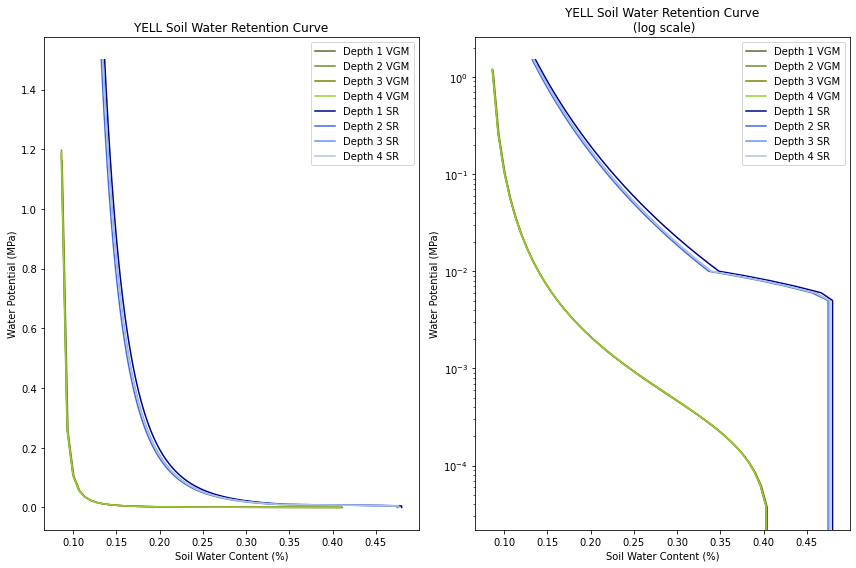

In [5]:
#Import nessisary modules
import pandas as pd     
import numpy as np
import matplotlib.pyplot as plt

#Read in soil texture .csv file and create dataframe
df = pd.read_csv('NEON.D12.YELL.DP1.00096.001.mgp_perbiogeosample.2018-07.basic.20201218T134226Z.csv')

#Get rid of unneccisary coloumns
YELL = df[['horizonName','sandTotal','siltTotal','clayTotal']]

#Extract soil texture proportions from dataset for each depth
#Depth 1  (A)
YELL_sand_A = YELL.loc[YELL['horizonName']=='A','sandTotal'].iloc[0]
YELL_silt_A = YELL.loc[YELL['horizonName']=='A','siltTotal'].iloc[0]
YELL_clay_A = YELL.loc[YELL['horizonName']=='A','clayTotal'].iloc[0]

#Depth 2 (Bt1)
YELL_sand_Bt1 = YELL.loc[YELL['horizonName']=='Bt1','sandTotal'].iloc[0]
YELL_silt_Bt1 = YELL.loc[YELL['horizonName']=='Bt1','siltTotal'].iloc[0]
YELL_clay_Bt1 = YELL.loc[YELL['horizonName']=='Bt1','clayTotal'].iloc[0]

#Depth 2 (Bt1)
YELL_sand_Bt1 = YELL.loc[YELL['horizonName']=='Bt1','sandTotal'].iloc[0]
YELL_silt_Bt1 = YELL.loc[YELL['horizonName']=='Bt1','siltTotal'].iloc[0]
YELL_clay_Bt1 = YELL.loc[YELL['horizonName']=='Bt1','clayTotal'].iloc[0]

#Depth 3 (Bt2)
YELL_sand_Bt2 = YELL.loc[YELL['horizonName']=='Bt2','sandTotal'].iloc[0]
YELL_silt_Bt2 = YELL.loc[YELL['horizonName']=='Bt2','siltTotal'].iloc[0]
YELL_clay_Bt2 = YELL.loc[YELL['horizonName']=='Bt2','clayTotal'].iloc[0]

#Depth 4 (Bw)
YELL_sand_Bw = YELL.loc[YELL['horizonName']=='Bw','sandTotal'].iloc[0]
YELL_silt_Bw = YELL.loc[YELL['horizonName']=='Bw','siltTotal'].iloc[0]
YELL_clay_Bw = YELL.loc[YELL['horizonName']=='Bw','clayTotal'].iloc[0]

#Return retention variables for the four depths using the van genuchten mualem model
t_Y_A_VG,h_Y_A = RetCurv_VGM(YELL_sand_A,YELL_silt_A,YELL_clay_A)
t_Y_Bt1_VG,h_Y_Bt1 = RetCurv_VGM(YELL_sand_Bt1,YELL_silt_Bt1,YELL_clay_Bt1)
t_Y_Bt2_VG,h_Y_Bt2 = RetCurv_VGM(YELL_sand_Bt2,YELL_silt_Bt2,YELL_clay_Bt2)
t_Y_Bw_VG,h_Y_Bw = RetCurv_VGM(YELL_sand_Bw,YELL_silt_Bw,YELL_clay_Bw)

#Return funtions for the four depths using the saxton rawl method
t1Y = RetCurv_SR(YELL_sand_A,YELL_clay_A)
t2Y = RetCurv_SR(YELL_sand_Bt1,YELL_clay_Bt1)
t3Y = RetCurv_SR(YELL_sand_Bt2,YELL_clay_Bt2)
t4Y = RetCurv_SR(YELL_sand_Bw,YELL_clay_Bw)

#Apply the closure function to the soil water potential array
t_Y_A_SR = [t1Y(p) for p in P]
t_Y_Bt1_SR = [t2Y(p) for p in P]
t_Y_Bt2_SR = [t3Y(p) for p in P]
t_Y_Bw_SR = [t4Y(p) for p in P]

#Plot curves one is normal scale, one is log scale (I noticed most examples had the pressure at a base ten log scale)
plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.plot(t_Y_A_VG,h_Y_A, color = 'darkolivegreen', label = 'Depth 1 VGM')
plt.plot(t_Y_Bt1_VG,h_Y_Bt1, color = 'olivedrab', label = 'Depth 2 VGM')
plt.plot(t_Y_Bt2_VG,h_Y_Bt2, color = 'olive', label = 'Depth 3 VGM')
plt.plot(t_Y_Bw_VG, h_Y_Bw, color = 'yellowgreen', label = 'Depth 4 VGM')
plt.plot(t_Y_A_SR, P_MPa, color = 'darkblue', label = 'Depth 1 SR')
plt.plot(t_Y_Bt1_SR, P_MPa, color = 'royalblue', label = 'Depth 2 SR')
plt.plot(t_Y_Bt2_SR, P_MPa, color = 'cornflowerblue', label = 'Depth 3 SR')
plt.plot(t_Y_Bw_SR, P_MPa, color = 'lightsteelblue', label = 'Depth 4 SR')
plt.xlabel("Soil Water Content (%)") 
plt.ylabel("Water Potential (MPa)")
plt.legend()
plt.title("YELL Soil Water Retention Curve")

plt.subplot(1, 2, 2)
plt.plot(t_Y_A_VG,h_Y_A, color = 'darkolivegreen', label = 'Depth 1 VGM')
plt.plot(t_Y_Bt1_VG,h_Y_Bt1, color = 'olivedrab', label = 'Depth 2 VGM')
plt.plot(t_Y_Bt2_VG,h_Y_Bt2, color = 'olive', label = 'Depth 3 VGM')
plt.plot(t_Y_Bw_VG, h_Y_Bw, color = 'yellowgreen', label = 'Depth 4 VGM')
plt.plot(t_Y_A_SR, P_MPa, color = 'darkblue', label = 'Depth 1 SR')
plt.plot(t_Y_Bt1_SR, P_MPa, color = 'royalblue', label = 'Depth 2 SR')
plt.plot(t_Y_Bt2_SR,P_MPa, color = 'cornflowerblue', label = 'Depth 3 SR')
plt.plot(t_Y_Bw_SR, P_MPa, color = 'lightsteelblue', label = 'Depth 4 SR')
plt.xlabel("Soil Water Content (%)") 
plt.ylabel("Water Potential (MPa)")
plt.yscale('log')
plt.legend()
plt.title("YELL Soil Water Retention Curve\n (log scale)")
    
plt.tight_layout()
plt.show()

## TEAK Site Soil Water Retention Curve (based on soil texture data)

/opt/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in power


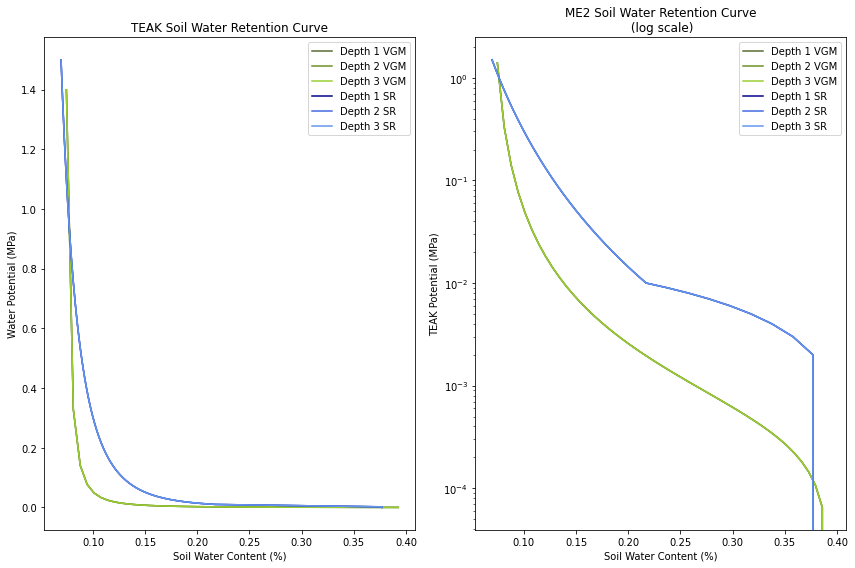

In [6]:
#Same soil texture ate each depth... (75/19/6)
TEAK_sand = 75
TEAK_silt = 19
TEAK_clay = 6

#Return retention variables for the three depths using the van genuchten mualem model
t_T_A_VG,h_T_A = RetCurv_VGM(TEAK_sand,TEAK_silt,TEAK_clay)
t_T_B_VG,h_T_B = RetCurv_VGM(TEAK_sand,TEAK_silt,TEAK_clay)
t_T_C_VG,h_T_C = RetCurv_VGM(TEAK_sand,TEAK_silt,TEAK_clay)

#Return funtions for the three depths using the saxton rawl method
t1T = RetCurv_SR(TEAK_sand,TEAK_clay)
t2T = RetCurv_SR(TEAK_sand,TEAK_clay)
t3T = RetCurv_SR(TEAK_sand,TEAK_clay)

#Apply the closure function to the soil water potential array
t_T_A_SR = [t1T(p) for p in P]
t_T_B_SR = [t2T(p) for p in P]
t_T_C_SR = [t3T(p) for p in P]

#Plot curves one is normal scale, one is log scale (I noticed most examples had the pressure at a base ten log scale)
plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.plot(t_T_A_VG, h_T_A, color = 'darkolivegreen', label = 'Depth 1 VGM')
plt.plot(t_T_B_VG, h_T_B, color = 'olivedrab', label = 'Depth 2 VGM')
plt.plot(t_T_C_VG, h_T_C, color = 'yellowgreen', label = 'Depth 3 VGM')
plt.plot(t_T_A_SR, P_MPa, color = 'darkblue', label = 'Depth 1 SR')
plt.plot(t_T_B_SR, P_MPa, color = 'royalblue', label = 'Depth 2 SR')
plt.plot(t_T_C_SR, P_MPa, color = 'cornflowerblue', label = 'Depth 3 SR')
plt.xlabel("Soil Water Content (%)") 
plt.ylabel("Water Potential (MPa)")
plt.legend()
plt.title("TEAK Soil Water Retention Curve")

plt.subplot(1, 2, 2)
plt.plot(t_T_A_VG, h_T_A, color = 'darkolivegreen', label = 'Depth 1 VGM')
plt.plot(t_T_B_VG, h_T_B, color = 'olivedrab', label = 'Depth 2 VGM')
plt.plot(t_T_C_VG, h_T_C, color = 'yellowgreen', label = 'Depth 3 VGM')
plt.plot(t_T_A_SR, P_MPa, color = 'darkblue', label = 'Depth 1 SR')
plt.plot(t_T_B_SR, P_MPa, color = 'royalblue', label = 'Depth 2 SR')
plt.plot(t_T_C_SR, P_MPa, color = 'cornflowerblue', label = 'Depth 3 SR')
plt.xlabel("Soil Water Content (%)") 
plt.ylabel("TEAK Potential (MPa)")
plt.yscale('log')
plt.legend()
plt.title("ME2 Soil Water Retention Curve\n (log scale)")
    
plt.tight_layout()
plt.show()

## US-Me2 Site Soil Water Retention Curve (based on soil texture data)

/opt/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in power


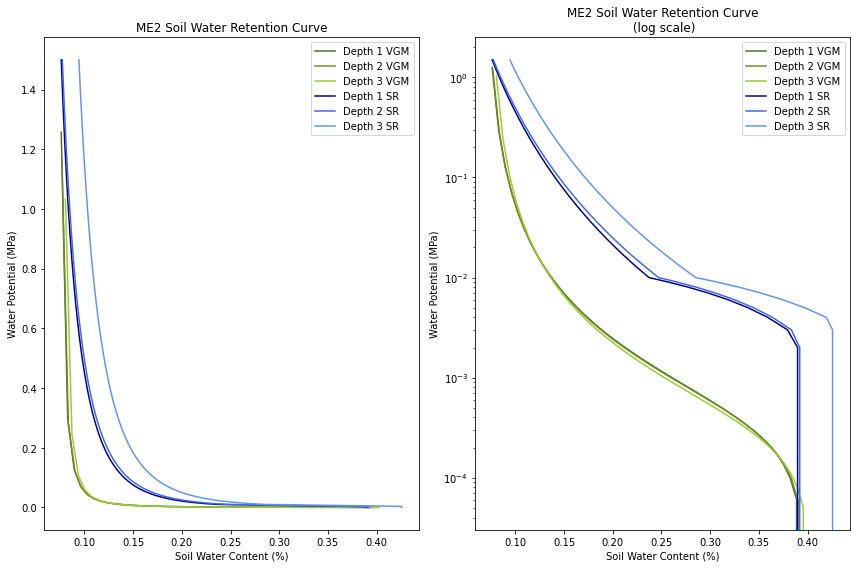

In [7]:
#Given:  Soils at the site are 69%/24%/7% sand/silt/clay at 0–0.2 m depth and 66%/27%/7% at 0.2–0.5 m depth, and 54%/ 35%/11% at 0.5–1.0 m depth
#Soil layer at 0–0.2 m depth 69%/24%/7% sand/silt/clay
ME2_sand_A = 69
ME2_silt_A = 24
ME2_clay_A = 7

#66%/27%/7% at 0.2–0.5 m depth
ME2_sand_B = 66
ME2_silt_B = 27
ME2_clay_B = 7

#54%/ 35%/11% at 0.5–1.0 m depth
ME2_sand_C = 54
ME2_silt_C = 35
ME2_clay_C = 11

#Return retention variables for the three depths using the van genuchten mualem model
t_M_A_VG,h_M_A = RetCurv_VGM(ME2_sand_A,ME2_silt_A,ME2_clay_A)
t_M_B_VG,h_M_B = RetCurv_VGM(ME2_sand_B,ME2_silt_B,ME2_clay_B)
t_M_C_VG,h_M_C = RetCurv_VGM(ME2_sand_C,ME2_silt_C,ME2_clay_C)

#Return funtions for the three depths using the saxton rawl method
t1M = RetCurv_SR(ME2_sand_A,ME2_clay_A)
t2M = RetCurv_SR(ME2_sand_B,ME2_clay_B)
t3M = RetCurv_SR(ME2_sand_C,ME2_clay_C)

#Apply the closure function to the soil water potential array
t_M_A_SR = [t1M(p) for p in P]
t_M_B_SR = [t2M(p) for p in P]
t_M_C_SR = [t3M(p) for p in P]

#Plot curves one is normal scale, one is log scale (I noticed most examples had the pressure at a base ten log scale)
plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.plot(t_M_A_VG, h_M_A, color = 'darkolivegreen', label = 'Depth 1 VGM')
plt.plot(t_M_B_VG, h_M_B, color = 'olivedrab', label = 'Depth 2 VGM')
plt.plot(t_M_C_VG, h_M_C, color = 'yellowgreen', label = 'Depth 3 VGM')
plt.plot(t_M_A_SR, P_MPa, color = 'darkblue', label = 'Depth 1 SR')
plt.plot(t_M_B_SR, P_MPa, color = 'royalblue', label = 'Depth 2 SR')
plt.plot(t_M_C_SR, P_MPa, color = 'cornflowerblue', label = 'Depth 3 SR')
plt.xlabel("Soil Water Content (%)") 
plt.ylabel("Water Potential (MPa)")
plt.legend()
plt.title("ME2 Soil Water Retention Curve")

plt.subplot(1, 2, 2)
plt.plot(t_M_A_VG, h_M_A, color = 'darkolivegreen', label = 'Depth 1 VGM')
plt.plot(t_M_B_VG, h_M_B, color = 'olivedrab', label = 'Depth 2 VGM')
plt.plot(t_M_C_VG, h_M_C, color = 'yellowgreen', label = 'Depth 3 VGM')
plt.plot(t_M_A_SR, P_MPa, color = 'darkblue', label = 'Depth 1 SR')
plt.plot(t_M_B_SR, P_MPa, color = 'royalblue', label = 'Depth 2 SR')
plt.plot(t_M_C_SR, P_MPa, color = 'cornflowerblue', label = 'Depth 3 SR')
plt.xlabel("Soil Water Content (%)") 
plt.ylabel("Water Potential (MPa)")
plt.yscale('log')
plt.legend()
plt.title("ME2 Soil Water Retention Curve\n (log scale)")
    
plt.tight_layout()
plt.show()